In [24]:
# Python libraries
import os, cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image
import SimpleITK as sitk
import seaborn as sns
import logging
import random
from concurrent.futures import ThreadPoolExecutor, as_completed

# Albumentation library
import albumentations as A

# Radiomics libraries
import radiomics
from radiomics import featureextractor

# Sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Set the pyradiomics logging level to ERROR to ignore warnings
radiomics_logger = logging.getLogger('radiomics')
radiomics_logger.setLevel(logging.ERROR)


# To make the results are reproducible
np.random.seed(42)
random.seed(42)

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Set path for radiomics pameter file
params = 'Parametry radiomiczne/params.yaml'

# Show if there are any folders where folders should be
print(os.listdir("../Baza danych"))

['HAM10000_images_part_1', 'HAM10000_images_part_2', 'HAM10000_metadata', 'HAM10000_segmentations_lesion_tschandl']


### Loading the dataset

In [25]:
data_dir = "../Baza danych"
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
all_masks_path = glob(os.path.join(data_dir, '*', '*.png'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
maskid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_masks_path}

# Defining new lesion names
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

### Loading the metadata and adding new columns 

<ul>
  <li>lesion_id -> this refers to the patient associated with the skin lesion</li>
  <li>image_id -> this refers to the image name in the HAM10000 data folders</li>
  <li>mask_id -> this refers to the mask name in the HAM10000 data folders</li> *Added
  <li>dx -> this refers to the diagnosis</li>
  <li>dx_type -> this refers to how the skin lesion is verified</li>
  <li>age -> this refers to the age of the patient associated with the skin lesion image</li>
  <li>sex -> this refers to the sex of the patient associated with the skin lesion image</li>
  <li>localization -> this refers to the location of the skin lesion on the body</li>
  <li>dataset -> this refers to the origin dataset for the skin lesion</li>
  <li>image_path -> this refers to the current path for each image</li>*Added
  <li>mask_path	 -> this refers to the current path for each mask</li> *Added
  <li>cell_type	 -> this refers to the full name of the diagnosis</li>*Added
  <li>cell_type_idx	 -> this refers to the categorical variable which corresponds to diagnosis</li> *Added
</ul>

In [26]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata'))
df_original.insert(2, 'mask_id', df_original['image_id'].astype(str) + '_segmentation')
df_original['image_path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['mask_path'] = df_original['mask_id'].map(maskid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()

,lesion_id,image_id,mask_id,dx,dx_type,age,sex,localization,dataset,image_path,mask_path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,ISIC_0027419_segmentation,bkl,histo,80.0,male,scalp,vidir_modern,../Baza danych\HAM10000_images_part_1\ISIC_002...,../Baza danych\HAM10000_segmentations_lesion_t...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,ISIC_0025030_segmentation,bkl,histo,80.0,male,scalp,vidir_modern,../Baza danych\HAM10000_images_part_1\ISIC_002...,../Baza danych\HAM10000_segmentations_lesion_t...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,ISIC_0026769_segmentation,bkl,histo,80.0,male,scalp,vidir_modern,../Baza danych\HAM10000_images_part_1\ISIC_002...,../Baza danych\HAM10000_segmentations_lesion_t...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,ISIC_0025661_segmentation,bkl,histo,80.0,male,scalp,vidir_modern,../Baza danych\HAM10000_images_part_1\ISIC_002...,../Baza danych\HAM10000_segmentations_lesion_t...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,ISIC_0031633_segmentation,bkl,histo,75.0,male,ear,vidir_modern,../Baza danych\HAM10000_images_part_2\ISIC_003...,../Baza danych\HAM10000_segmentations_lesion_t...,Benign keratosis-like lesions,2


### Cleaning the dataset from duplicates and preparing dataframes for training and augmentation

In [27]:
# This will tell us how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# Now we filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,mask_id,dx,dx_type,age,sex,localization,dataset,image_path,mask_path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1,1,1,1


In [28]:
# Here we identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# Create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']

# Apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,mask_id,dx,dx_type,age,sex,localization,dataset,image_path,mask_path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,ISIC_0027419_segmentation,bkl,histo,80.0,male,scalp,vidir_modern,../Baza danych\HAM10000_images_part_1\ISIC_002...,../Baza danych\HAM10000_segmentations_lesion_t...,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,ISIC_0025030_segmentation,bkl,histo,80.0,male,scalp,vidir_modern,../Baza danych\HAM10000_images_part_1\ISIC_002...,../Baza danych\HAM10000_segmentations_lesion_t...,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,ISIC_0026769_segmentation,bkl,histo,80.0,male,scalp,vidir_modern,../Baza danych\HAM10000_images_part_1\ISIC_002...,../Baza danych\HAM10000_segmentations_lesion_t...,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,ISIC_0025661_segmentation,bkl,histo,80.0,male,scalp,vidir_modern,../Baza danych\HAM10000_images_part_1\ISIC_002...,../Baza danych\HAM10000_segmentations_lesion_t...,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,ISIC_0031633_segmentation,bkl,histo,75.0,male,ear,vidir_modern,../Baza danych\HAM10000_images_part_2\ISIC_003...,../Baza danych\HAM10000_segmentations_lesion_t...,Benign keratosis-like lesions,2,duplicated


In [29]:
# Checking number of duplicates
df_original['duplicates'].value_counts()

duplicates
unduplicated    5514
duplicated      4501
Name: count, dtype: int64

In [30]:
# Now we filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 14)

In [31]:
# Now we create a val set using df because we are sure that none of these images have augmented duplicates in the train set
y = df_undup['cell_type_idx']
_, df_test = train_test_split(df_undup, test_size=0.2, random_state=42, stratify=y)
df_test.shape

(1103, 14)

In [32]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.
def get_test_rows(x):
    # Create a list of all the lesion_id's in the val set
    val_list = list(df_test['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# Identify train and val rows
# Create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image_id']
# Apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_test_rows)
# Filter out train rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(df_test))

8912
1103


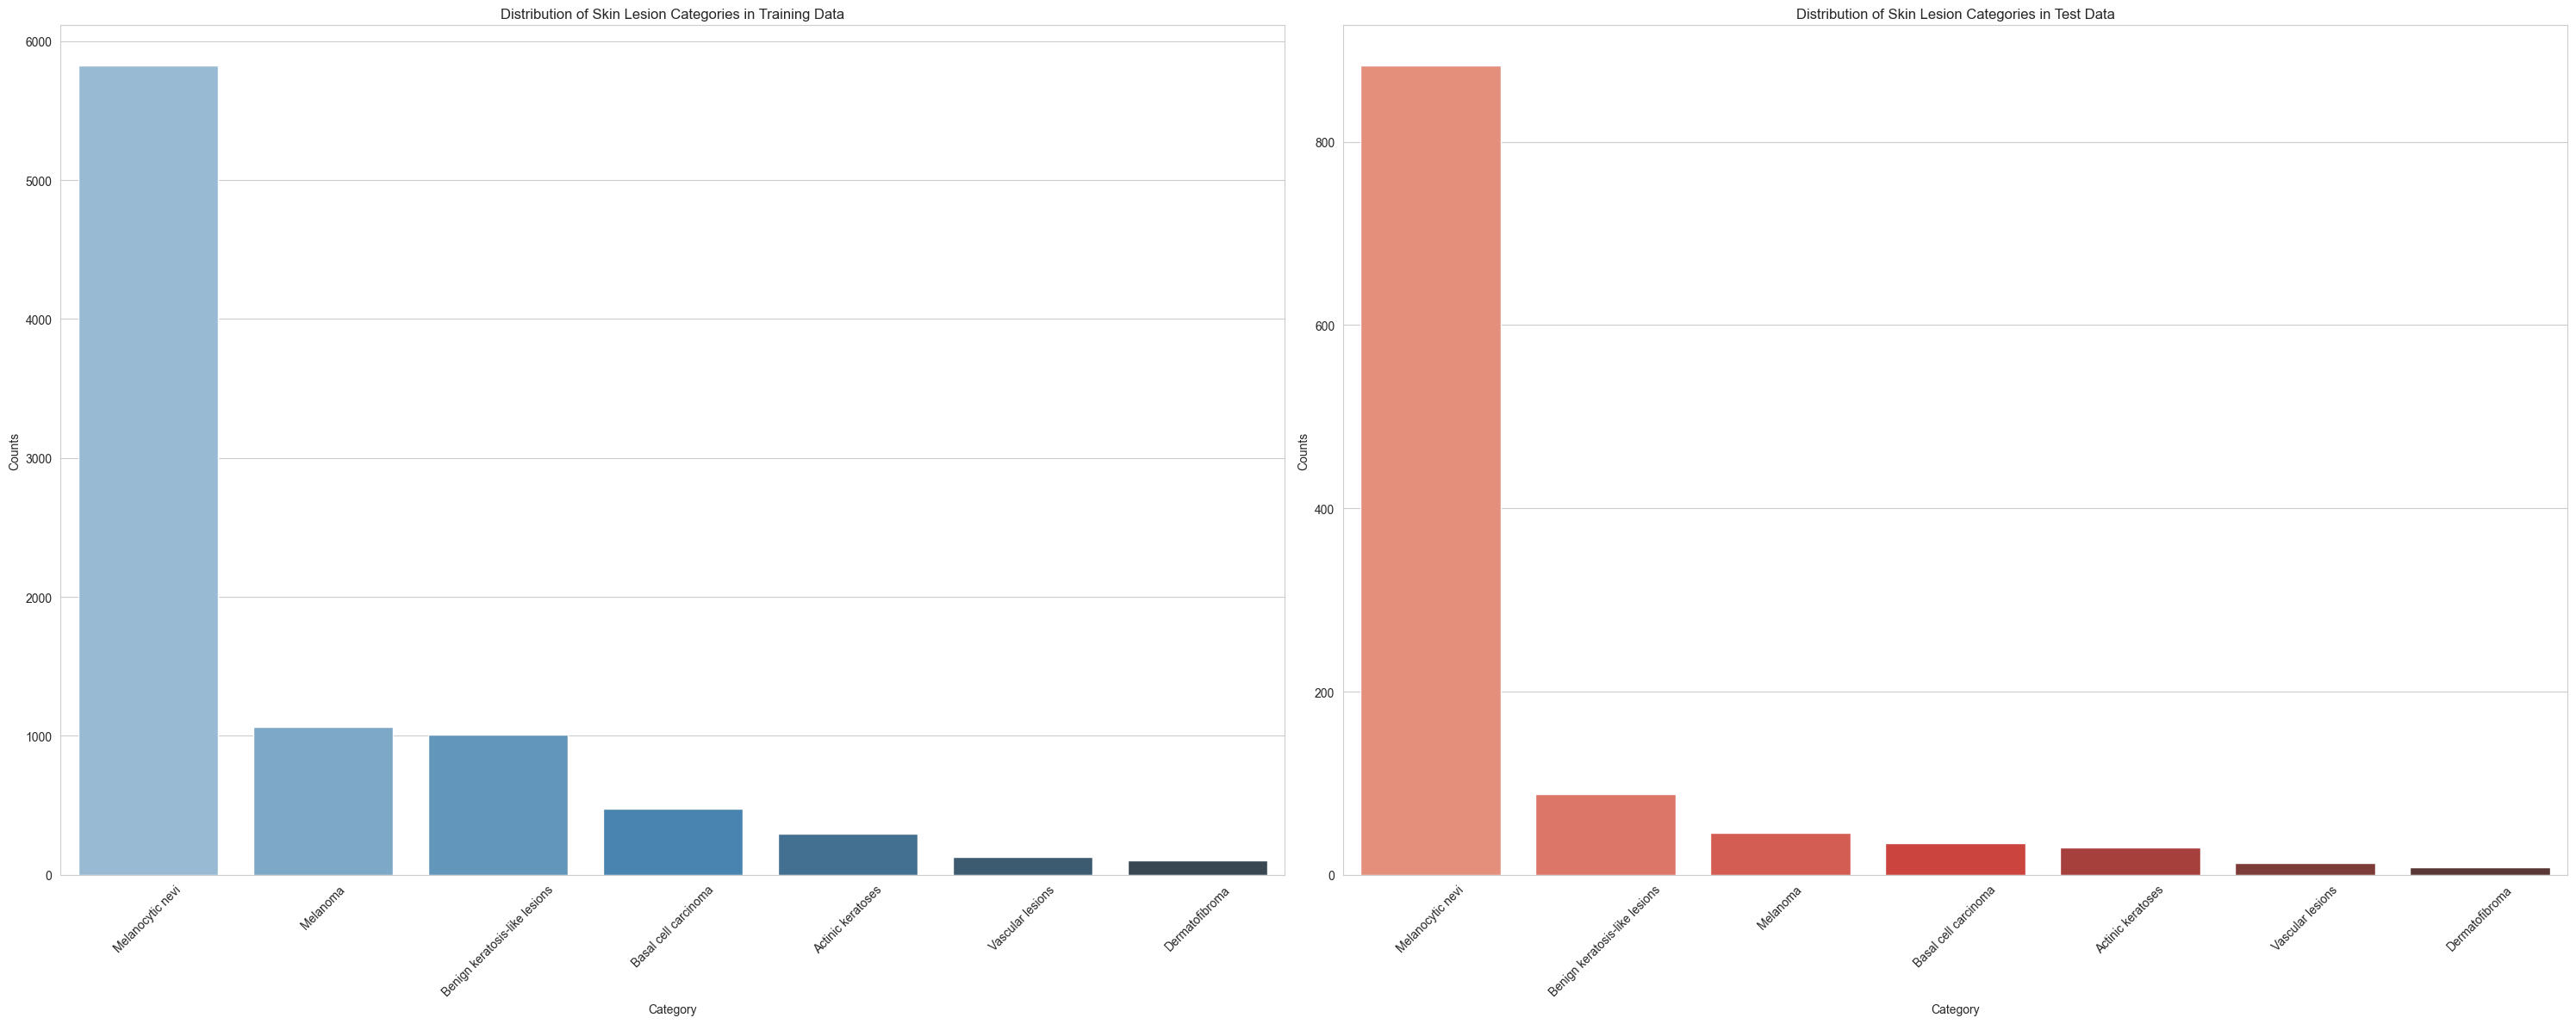

In [33]:
# Count occurrences for both datasets
train_category_counts = df_train['cell_type'].value_counts().reset_index()
train_category_counts.columns = ['Category', 'Counts']
test_category_counts = df_test['cell_type'].value_counts().reset_index()
test_category_counts.columns = ['Category', 'Counts']

# Create a figure to hold the subplots
plt.figure(figsize=(30, 12))

# Subplot 1: Training Data
plt.subplot(1, 2, 1) # (rows, columns, subplot number)
sns.barplot(x='Category', y='Counts', hue='Category', data=train_category_counts, palette="Blues_d", legend=False)
plt.xticks(rotation=45)
plt.title('Distribution of Skin Lesion Categories in Training Data')
plt.xlabel('Category')
plt.ylabel('Counts')

# Subplot 2: Test Data
plt.subplot(1, 2, 2) # (rows, columns, subplot number)
sns.barplot(x='Category', y='Counts', hue='Category', data=test_category_counts, palette="Reds_d", legend=False)
plt.xticks(rotation=45)
plt.title('Distribution of Skin Lesion Categories in Test Data')
plt.xlabel('Category')
plt.ylabel('Counts')

# Show the plots
plt.tight_layout()
plt.show()

### Augmentation

In [34]:
# Set eate at which images in each class will be augmented
data_aug_rate = [18, 12, 5, 50, 0, 5, 40]
dfs_to_concat = []

for i in range(7):
    if data_aug_rate[i]:
        subset = df_train.loc[df_train['cell_type_idx'] == i, :]
        duplicated_subset = [subset] * (data_aug_rate[i] - 1)
        dfs_to_concat.extend(duplicated_subset)

# Adding all copies to train dataframe
df_train = pd.concat([df_train] + dfs_to_concat, ignore_index=True)
df_train['cell_type'].value_counts()

cell_type
Melanocytic nevi                 5822
Basal cell carcinoma             5748
Dermatofibroma                   5350
Actinic keratoses                5346
Melanoma                         5335
Vascular lesions                 5160
Benign keratosis-like lesions    5055
Name: count, dtype: int64

In [35]:
# Index reset before we begin (just to be sure)
df_train = df_train.reset_index()
df_test = df_test.reset_index()

In [36]:
# Define transformations of the train image
# For some reason default value of is_check_shapes causes error
transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ColorJitter(p=0.2, brightness=0.1, contrast=0.1, hue=0.1),
    A.Rotate(limit=20, p=0.5), 
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
    A.RandomResizedCrop(height=224, width=224, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.1),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.5),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
    A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=5, p=0.2)], is_check_shapes=False, additional_targets={})

# Define transformations of the test image
transform = A.Compose([A.Resize(256, 256)], is_check_shapes=False)

### Radiomics

In [37]:
# This function allows me to extract the features of the colors I have selected -> Second approach
def plain_color_extraction(img):
    b, g, r = cv2.split(img)
    mean_b, std_b = cv2.meanStdDev(b)
    mean_g, std_g = cv2.meanStdDev(g)
    mean_r, std_r = cv2.meanStdDev(r)
    return {"mean_b": mean_b, "std_b": std_b, "mean_g": mean_g, "std_g": std_g, "mean_r": mean_r, "std_r": std_r}

In [38]:
# This function allows me augment masks and images and is same for all three approaches

def augmentation(df, index, transform):
    # Load data and get label
    X = cv2.imread(df['image_path'][index])
    X = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
    y = cv2.imread(df['mask_path'][index], 0)

    transformed = transform(image=X, mask=y)
    X = transformed['image']
    y = transformed['mask']

    X_rad = cv2.cvtColor(X, cv2.COLOR_RGB2GRAY)

    X_rad = sitk.GetImageFromArray(X_rad)
    y_rad = sitk.GetImageFromArray(y)

    return X, y, X_rad, y_rad

In [39]:
# This function processes input dataframe to create a NumPy array 
# that holds numerical values corresponding 
# to the specified features for each case (row) in the dataframe
def get_samples(df, feature_names, results):
    samples = np.zeros((len(df),len(feature_names)))
    for case_id in range(0 ,len(df)):
        a = np.array([])
        for feature_name in feature_names:
            a = np.append(a, results[case_id][feature_name])
        samples[case_id,:] = a
    # May have NaNs
    samples = np.nan_to_num(samples)
    return samples

In [40]:
# This function creates summary dataframe from radiomics results
def summary(results, df):
    # List that holds all feature names     
    feature_names = list(sorted(filter ( lambda k: k.startswith("original_"), results[0] )))

    # Numpy array 
    samples = get_samples(df, feature_names, results)

    # Initializing summary dataframe
    features_df = pd.DataFrame(samples)
    features_df.columns = feature_names

    # Mapping categories to summary dataframe
    categories_df = pd.DataFrame()
    mapping = {'Actinic keratoses': 0, 'Basal cell carcinoma': 1, 
            'Benign keratosis-like lesions': 2, 'Dermatofibroma': 3,
            'Melanocytic nevi': 4, 'Vascular lesions': 5, 'Melanoma':6}
    categories_df['category'] = df['cell_type'].replace(mapping)

    # Summing up dataframes
    df_result = pd.concat([features_df, categories_df], axis=1)

    return df_result

In [41]:
# This function creates summary dataframe from color features results
def summary_col(results, df):
    # List that holds all feature names     
    feature_names = list(sorted(results[0].keys()))

    # Numpy array 
    samples = get_samples(df, feature_names, results)

    # Initializing summary dataframe
    features_df = pd.DataFrame(samples)
    features_df.columns = feature_names

    # Mapping categories to summary dataframe
    categories_df = pd.DataFrame()
    mapping = {'Actinic keratoses': 0, 'Basal cell carcinoma': 1, 
            'Benign keratosis-like lesions': 2, 'Dermatofibroma': 3,
            'Melanocytic nevi': 4, 'Vascular lesions': 5, 'Melanoma':6}
    categories_df['category'] = df['cell_type'].replace(mapping)

    # Summing up dataframes
    df_result = pd.concat([features_df, categories_df], axis=1)

    return df_result

In [42]:
# Select an approach number
# 0 -> Colorless radiomics extraction
# 1 -> Own color features + colorless radiomics extraction
# 2 -> Radiomics color extraction + colorless radiomics extraction
approach_num = 2

# Initializing radiomic extractor
extractor = featureextractor.RadiomicsFeatureExtractor(params)

In [43]:
# These lines are just for getting all feature names as I am not aware of any method that would allow me to view them
X, y, X_rad, y_rad = augmentation(df_train, 0, transforms)
test = extractor.execute(X_rad, y_rad)
all_features = list(sorted(filter ( lambda k: k.startswith("original_"), test )))

In [44]:
# Function to generate a dictionary of features with zero values in case of mask error and to later delete them
def generate_zero_features(feature_names):
    # Assuming these are the features you're interested in; adjust as necessary
    return {feature: 0 for feature in feature_names}

In [45]:
# ----------------------------------------------------------------------------------
# First approach
if approach_num == 0:
    print('-------------------------')
    print('Proceed with training set')
    print('-------------------------')
    results = []
    for i in tqdm(range(len(df_train)), desc="Processing"):
        X, y, X_rad, y_rad = augmentation(df_train, i, transforms)
        try:
            result = extractor.execute(X_rad, y_rad)
        except Exception as e:
            print(f"No labels found in mask for {df_train['image_id'][i]}. Assigning zero values to features.")
            result = generate_zero_features(all_features)

        results.append(result)

    # Creating summary dataframe that has all feature results for all lesions
    summary_df = summary(results, df_train)
    summary_df = summary_df[~(summary_df.iloc[:, :-1] == 0).all(axis=1)]
    summary_df.to_csv('Csv/first.csv')
    print('-------------------------')
    print('Proceed with test set')
    print('-------------------------')
    results = []
    for i in tqdm(range(len(df_test)), desc="Processing"):
        X, y, X_rad, y_rad = augmentation(df_test, i, transforms)
        try:
            result = extractor.execute(X_rad, y_rad)
        except Exception as e:
            print(f"No labels found in mask for {df_test['image_id'][i]}. Assigning zero values to features.")
            result = generate_zero_features(all_features)

        results.append(result)

    # Creating summary dataframe that has all feature results for all lesions
    summary_df_test = summary(results, df_test)
    summary_df_test = summary_df_test[~(summary_df_test.iloc[:, :-1] == 0).all(axis=1)]
    summary_df_test.to_csv('Csv/first_test.csv')
# ----------------------------------------------------------------------------------
# Second approach
if approach_num == 1:
    print('-------------------------')
    print('Proceed with training set')
    print('-------------------------')
    results = []
    results_color = []
    for i in tqdm(range(len(df_train)), desc="Processing"):
        X, y, X_rad, y_rad = augmentation(df_train, i, transforms)
        # Expand dimensions of mask array
        label = np.expand_dims(y, axis=2)
        newmask = np.concatenate((label, label, label), axis=2)
        # Multiply new mask with image
        cob = X * newmask
        try:
            result = extractor.execute(X_rad, y_rad)
            result_color = plain_color_extraction(cob)
        except Exception as e:
            print(f"No labels found in mask for {df_train['image_id'][i]}. Assigning zero values to features.")
            result_color = plain_color_extraction(cob)
        results.append(result)
        results_color.append(result_color)
    
    # Creating summary dataframe that has all feature results for all lesions
    summary_df_normal = summary(results, df_train)
    summary_df_normal = summary_df_normal.iloc[:, :-1]  # Select all columns except the last one
    summary_df_color = summary_col(results_color, df_train)
    summary_df  = pd.concat([summary_df_normal, summary_df_color], axis=1)
    summary_df.to_csv('Csv/second.csv')
    print('-------------------------')
    print('Proceed with test set')
    print('-------------------------')
    for i in tqdm(range(len(df_test)), desc="Processing"):
        X, y, X_rad, y_rad = augmentation(df_test, i, transforms)
        # Expand dimensions of mask array
        label = np.expand_dims(y, axis=2)
        newmask = np.concatenate((label, label, label), axis=2)
        # Multiply new mask with image
        cob = X * newmask
        try:
            result = extractor.execute(X_rad, y_rad)
            result_color = plain_color_extraction(cob)
        except Exception as e:
            print(f"No labels found in mask for {df_test['image_id'][i]}. Assigning zero values to features.")
            result_color = plain_color_extraction(cob)
        results.append(result)
        results_color.append(result_color)

    # Creating summary dataframe that has all feature results for all lesions
    summary_df_normal = summary(results, df_test)
    summary_df_normal = summary_df_normal.iloc[:, :-1]  # Select all columns except the last one
    summary_df_color = summary_col(results_color, df_test)
    summary_df_test  = pd.concat([summary_df_normal, summary_df_color], axis=1)
    summary_df.to_csv('Csv/second_test.csv')

# ----------------------------------------------------------------------------------
# Third approach
if approach_num == 2:
    print('-------------------------')
    print('Proceed with training set')
    print('-------------------------')
    results = []
    results_r = []
    results_g = []
    results_b = []
    for i in tqdm(range(len(df_train)), desc="Processing"):
        X, y, X_rad, y_rad = augmentation(df_train, i, transforms)
        # Split the RGB image into three separate channels
        R_channel, G_channel, B_channel = cv2.split(X)

        # Convert each channel into a SimpleITK Image
        sitk_R = sitk.GetImageFromArray(R_channel)
        sitk_G = sitk.GetImageFromArray(G_channel)
        sitk_B = sitk.GetImageFromArray(B_channel)

        result = extractor.execute(X_rad, y_rad)
        results.append(result)
        result_r = extractor.execute(sitk_R, y_rad)
        results_r.append(result_r)
        result_g = extractor.execute(sitk_R, y_rad)
        results_g.append(result_g)
        result_b = extractor.execute(sitk_R, y_rad)
        results_b.append(result_b)
        
    # Creating summary dataframe that has all feature results for all lesions
    summary_df_normal = summary(results, df_train)
    summary_df_normal = summary_df_normal.iloc[:, :-1]  # Select all columns except the last one
    summary_df_red = summary(results_r, df_train)
    summary_df_red.columns = [name if name.endswith('_r') else name + '_r' for name in summary_df_red.columns]
    summary_df_red = summary_df_red.iloc[:, :-1]  # Select all columns except the last one
    summary_df_green = summary(results_g, df_train)
    summary_df_green.columns = [name if name.endswith('_g') else name + '_g' for name in summary_df_green.columns]
    summary_df_green = summary_df_green.iloc[:, :-1]  # Select all columns except the last one
    summary_df_blue = summary(results_b, df_train)
    summary_df_blue.columns = [name + '_b' if not name.endswith('_b') and summary_df_blue.columns.get_loc(name) != len(summary_df_blue.columns) - 1 else name for name in summary_df_blue.columns]
    summary_df  = pd.concat([summary_df_normal, summary_df_red, summary_df_green, summary_df_blue], axis=1)
    summary_df.to_csv('Csv/third.csv')
    print('-------------------------')
    print('Proceed with test set')
    print('-------------------------')
    results = []
    results_r = []
    results_g = []
    results_b = []
    for i in tqdm(range(len(df_test)), desc="Processing"):
        X, y, X_rad, y_rad = augmentation(df_test, i, transforms)
        # Split the RGB image into three separate channels
        R_channel, G_channel, B_channel = cv2.split(X)

        # Convert each channel into a SimpleITK Image
        sitk_R = sitk.GetImageFromArray(R_channel)
        sitk_G = sitk.GetImageFromArray(G_channel)
        sitk_B = sitk.GetImageFromArray(B_channel)

        result = extractor.execute(X_rad, y_rad)
        results.append(result)
        result_r = extractor.execute(sitk_R, y_rad)
        results_r.append(result_r)
        result_g = extractor.execute(sitk_R, y_rad)
        results_g.append(result_g)
        result_b = extractor.execute(sitk_R, y_rad)
        results_b.append(result_b)
        
    # Creating summary dataframe that has all feature results for all lesions
    summary_df_normal = summary(results, df_test)
    summary_df_normal = summary_df_normal.iloc[:, :-1]  # Select all columns except the last one
    summary_df_red = summary(results_r, df_test)
    summary_df_red.columns = [name if name.endswith('_r') else name + '_r' for name in summary_df_red.columns]
    summary_df_red = summary_df_red.iloc[:, :-1]  # Select all columns except the last one
    summary_df_green = summary(results_g, df_test)
    summary_df_green.columns = [name if name.endswith('_g') else name + '_g' for name in summary_df_green.columns]
    summary_df_green = summary_df_green.iloc[:, :-1]  # Select all columns except the last one
    summary_df_blue = summary(results_b, df_test)
    summary_df_blue.columns = [name + '_b' if not name.endswith('_b') and summary_df_blue.columns.get_loc(name) != len(summary_df_blue.columns) - 1 else name for name in summary_df_blue.columns]

    summary_df  = pd.concat([summary_df_normal, summary_df_red, summary_df_green, summary_df_blue], axis=1)
    summary_df.to_csv('Csv/third_test.csv')



-------------------------
Proceed with training set
-------------------------


Processing:  57%|█████▋    | 21370/37816 [2:26:40<2:06:58,  2.16it/s]

In [ ]:
summary_df

,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,...,original_shape2D_PerimeterSurfaceRatio,original_shape2D_PixelSurface,original_shape2D_Sphericity,mean_b,mean_g,mean_r,std_b,std_g,std_r,category
0,57.0,141.0,2.210956e+08,2.273663,61.0,1.985778,216.0,103.248445,28.811175,112.0,...,0.031712,18809.0,0.815084,47.972158,61.585639,58.389389,65.370587,82.081981,79.754660,2
1,108.0,180.0,7.373545e+08,2.234361,37.0,3.699461,248.0,148.223357,22.866417,153.0,...,0.024593,32325.0,0.801735,8.778833,14.792626,13.831563,24.702270,41.648144,40.824689,2
2,150.0,180.0,4.134513e+08,1.309374,14.0,7.041578,254.0,166.485699,9.623215,168.0,...,0.047307,14824.0,0.615480,18.149653,29.449279,32.743423,28.672421,46.134972,51.675489,2
3,97.0,207.0,1.231923e+08,2.751471,61.0,2.434770,248.0,152.074492,33.704443,153.0,...,0.059405,4967.0,0.846748,5.905911,12.407585,10.868144,21.068723,39.760175,36.099193,2
4,143.0,214.0,3.410122e+09,2.174516,37.0,3.405267,255.0,179.920318,21.930790,182.0,...,0.012405,102934.0,0.890732,18.452952,33.753341,31.676478,25.258674,48.230721,47.036468,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37811,75.0,161.0,4.599595e+07,2.527123,41.0,3.839482,255.0,116.729032,26.381394,116.0,...,0.070955,3100.0,0.897384,3.517319,10.788584,8.620675,15.924112,43.583320,34.790089,5
37812,23.0,133.0,1.685479e+08,2.527852,56.0,3.060791,231.0,64.724109,33.926532,49.0,...,0.022715,28620.0,0.922481,13.772800,14.156759,19.791319,43.323651,53.156016,58.666643,5
37813,50.0,119.0,9.674267e+07,2.004897,39.0,2.722312,187.0,75.572877,23.111882,66.0,...,0.033073,14895.0,0.878261,4.977119,7.815548,9.950000,21.951949,40.383361,41.611485,5
37814,91.0,186.0,3.052691e+08,2.388287,50.0,2.377774,220.0,129.762660,28.832231,120.0,...,0.029402,16904.0,0.927332,2.663022,10.713311,6.993504,11.244670,43.129197,28.104175,5
